# This notebook is dedicated to the integration of XAI technologies to the state-of-the art models
### MSC/DSA/134

In [1]:
# import required packages
from globals.pandas_functions import *
import xgboost as xgb
from sklearn.metrics import accuracy_score
import joblib
import globals.data_utils as data_utils
import shap
import lime
import lime.lime_tabular
import time
import matplotlib.pyplot as plt
from globals.pandas_functions import *
import globals.explainers.shap_explainer as shap_explainer

C:\Users\PM User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define base path
root_path = "data/processed/null_value_option_1_with_validation_set"

In [3]:
# get feature names
feature_names_json = root_path + "/dataset_feature_names.json"

import json
with open(feature_names_json, 'r') as f:
    feature_names = json.load(f)

print("Feature names loaded:")
print(feature_names)


Feature names loaded:
['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'M4', 'M1_T', 'M2_T', 'M3_T', 'M6_T']


In [4]:
# import evaluation functions
from globals.model_evaluations import (
    evaluate_accuracy, evaluate_precision, evaluate_recall,
    evaluate_f1_score, evaluate_roc_auc
)
from sklearn.metrics import roc_auc_score, average_precision_score

In [5]:
# define fitted models path
fitted_models_base = "models/state_of_the_art/"

In [6]:
# without PCA selected features
data_base_path = root_path + "/scaled_and_balanced"


X_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_train_balanced.csv")
X_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_validation_scaled.csv")
X_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_test_scaled.csv")

y_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_train_balanced.csv")
y_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_validation.csv")
y_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_test.csv")

In [5]:
dataset_dimension("X_train", X_train)
dataset_dimension("X_test", X_test)

X_train dataset dimension: (683822, 26)
X_test dataset dimension: (118102, 26)


In [6]:
# view class distributions
data_utils.show_class_distribution(X_train, y_train.to_numpy().ravel(), "Class distribution of original dataset")
data_utils.show_class_distribution(X_test, y_test.to_numpy().ravel(), "Class distribution of test dataset")


Class distribution of original dataset:
  Total samples: 683822
  Y df samples:  [0 0 0 ... 1 1 1]
  Class 0 (non-fraud): 341911 (50.00%)
  Class 1 (fraud): 341911 (50.00%)

Class distribution of test dataset:
  Total samples: 118102
  Y df samples:  [0 0 1 ... 0 0 0]
  Class 0 (non-fraud): 113971 (96.50%)
  Class 1 (fraud): 4131 (3.50%)


In [7]:
# 01. SVM Model with XAI Integration

# load SVM model
svm_model = joblib.load(fitted_models_base + "svm_linear_model.joblib")

In [8]:
# make predictions and get probabilities for evaluation
y_pred = svm_model.predict(X_test.to_numpy())
y_pred_probability = svm_model.predict_proba(X_test.to_numpy())

In [10]:
# comprehensive SVM evaluation metrics
y_test_flat = y_test.to_numpy().ravel()
y_pred_proba_pos = y_pred_probability[:, 1]

print("="*50)
print("SVM MODEL EVALUATION")
print("="*50)

# basic metrics
svm_acc = evaluate_accuracy(y_test_flat, y_pred)
svm_prec = evaluate_precision(y_test_flat, y_pred, average="binary")
svm_rec = evaluate_recall(y_test_flat, y_pred, average="binary")
svm_f1 = evaluate_f1_score(y_test_flat, y_pred, average="binary")

# auc metrics
svm_auroc = roc_auc_score(y_test_flat, y_pred_proba_pos)
svm_auprc = average_precision_score(y_test_flat, y_pred_proba_pos)

print(f"AUROC: {svm_auroc:.4f}")
print(f"AUPRC: {svm_auprc:.4f}")

print(f"\nSummary Metrics:")
print(f"  Accuracy:  {svm_acc:.4f}")
print(f"  Precision: {svm_prec:.4f}")
print(f"  Recall:    {svm_rec:.4f}")
print(f"  F1 Score:  {svm_f1:.4f}")
print(f"  AUROC:     {svm_auroc:.4f}")
print(f"  AUPRC:     {svm_auprc:.4f}")

SVM MODEL EVALUATION
Accuracy: 0.9659 (96.59%)
Precision (binary): 0.9569
Recall (binary): 0.0269
F1-Score (binary): 0.0523
AUROC: 0.6838
AUPRC: 0.2699

Summary Metrics:
  Accuracy:  0.9659
  Precision: 0.9569
  Recall:    0.0269
  F1 Score:  0.0523
  AUROC:     0.6838
  AUPRC:     0.2699


In [16]:
# set XAI meta data
test_for_fraud = 1
interpretability_index = y_test.index[y_test["isFraud"] == test_for_fraud][0]
y_instance = y_test.loc[interpretability_index]
print(f"search index: {interpretability_index} \ny_instance: {y_instance}")

search index: 2 
y_instance: isFraud    1
Name: 2, dtype: int64


## 02. SHAP Integration
Integrating SHAP (SHapley Additive exPlanations) to explain the SVM model's predictions. using KernelExplainer as it is model-agnostic and works with SVMs.

In [15]:
shap = shap_explainer.SHAPExplainer(svm_model.predict_proba, X_train, X_test, feature_names)
shap.explain()

Generating SHAP Explainer...
SHAP Explainer initialization time: 0.01 seconds
Calculating SHAP values for 20 test samples...


100%|██████████| 20/20 [08:36<00:00, 25.85s/it]

SHAP values computation time: 516.97 seconds


SHAP Summary Plot (Bar):


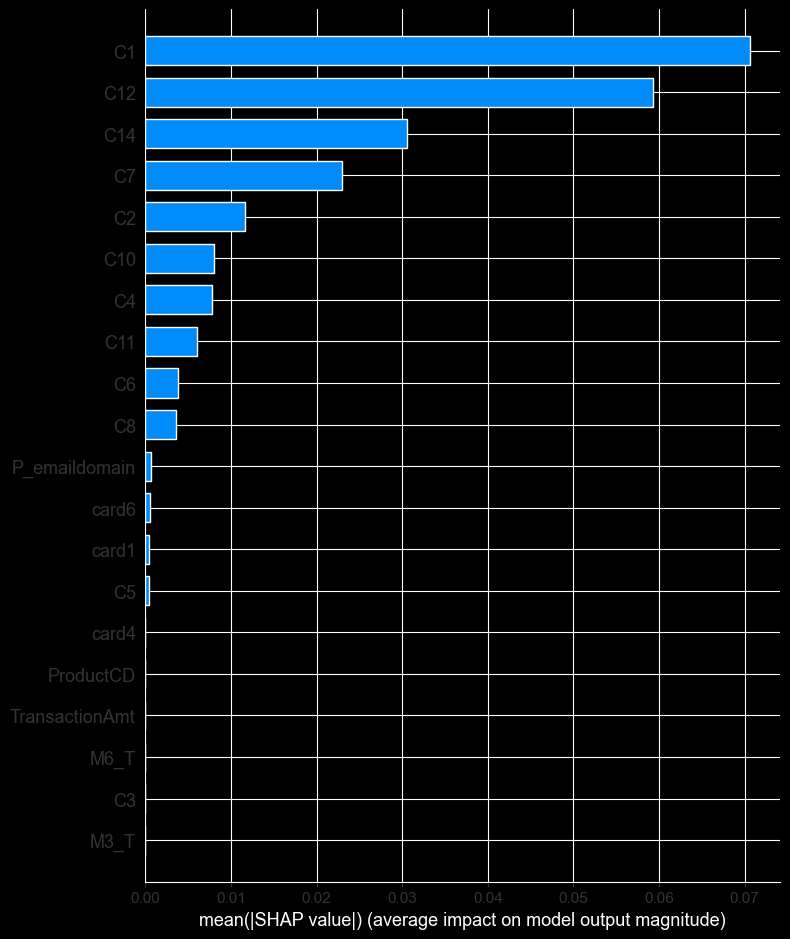

SHAP Summary Plot (Dot):


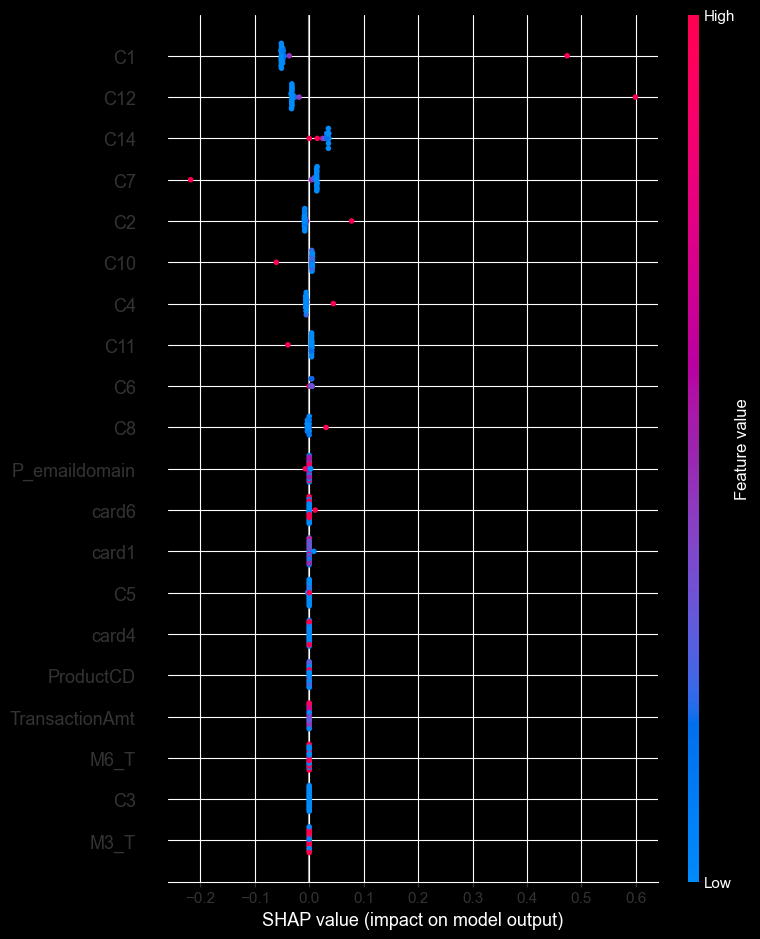

In [17]:
# show SHAP summary plot for global feature importance
shap.show_global_summary_plots()

SHAP Force Plot for instance: 2:
Base value used: 0.0725220805487127


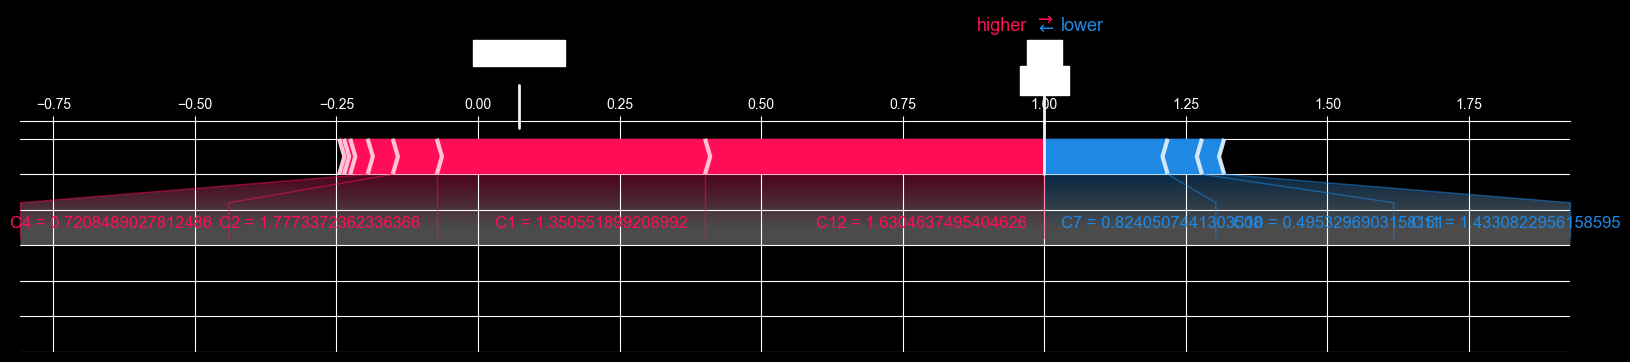

In [18]:
# show SHAP force plot for the specific instance
shap.show_local_interpretability(interpretability_index)

In [19]:
# get feature importance of the specific instance

# export shap values
xai_results_path = "xai_outputs/state_of_the_art/"
file_name = "svm_shap_result.csv"

shap.get_feature_influence(interpretability_index,xai_results_path, file_name)
# todo: fix issues here


--- Detailed Feature Influences for Instance 2 ---


ValueError: Per-column arrays must each be 1-dimensional

## 03. LIME Integration
Integrating LIME (Local Interpretable Model-agnostic Explanations) to explain individual predictions.

In [44]:
# Create LIME Explainer
print("Generating LIME Explainer...")

start_time = time.time()

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(),
    feature_names=feature_names,
    class_names=['Non-Fraud', 'Fraud'],
    mode='classification'
)

lime_init_time = time.time() - start_time

print(f"LIME Explainer initialization time: {lime_init_time:.2f} seconds")

# Explain a specific instance
instance_idx = interpretability_index # use search index from earlier to explain a known fraud instance
instance = X_test.iloc[instance_idx].values

print(f"Explaining instance {instance_idx} with LIME...")

start_time = time.time()
lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=svm_model.predict_proba,
    num_features=10
)

lime_compute_time = time.time() - start_time
print(f"LIME explanation computation time: {lime_compute_time:.2f} seconds")

Generating LIME Explainer...
LIME Explainer initialization time: 3.39 seconds
Explaining instance 2 with LIME...
LIME explanation computation time: 0.62 seconds


LIME Explanation Plot:


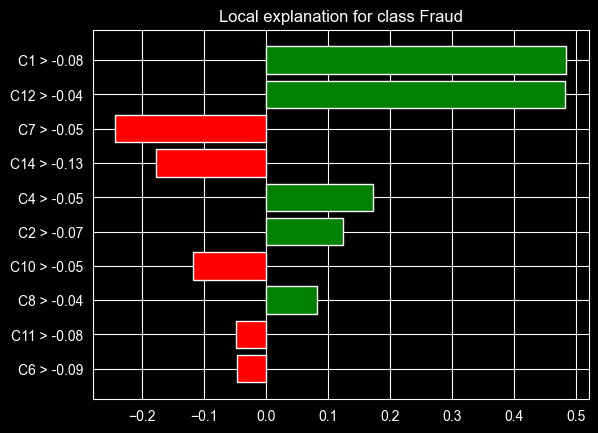

Y values: [1]


In [46]:
# Show LIME explanation in notebook (HTML)
# lime_exp.show_in_notebook(show_table=True)

# Display as pyplot figure for static view
print("LIME Explanation Plot:")
lime_exp.as_pyplot_figure()
plt.show()

print(f"Y values: {y_test.iloc[instance_idx].values}")

## 04. Comparison and Evaluation

### Usage and Performance Evaluation

**1. Computational Efficiency:**
- **SHAP (KernelExplainer):** Generally slower because it estimates Shapley values by perturbing features and running the model multiple times for each instance. It scales with the number of background samples and features.
- **LIME:** Typically faster as it builds a local linear model around the instance being explained. It requires fewer model evaluations than Kernel SHAP for a similar level of approximation in many cases.

**2. Explanation Consistency (Global vs Local):**
- **SHAP:** Provides consistent mathematical guarantees (additivity). It offers both local (force plots) and global (summary plots) interpretability. The global summary is very powerful for understanding the model's overall behavior.
- **LIME:** Focuses primarily on local interpretability. It approximates the model locally, and while it's good for understanding single predictions, it lacks a unified global view out-of-the-box.

**3. Visualization:**
- **SHAP:** The summary plot provides a dense information view (feature importance + direction of impact). The force plot effectively shows the "push and pull" of features.
- **LIME:** The bar chart is intuitive for showing positive/negative contributions for a single instance, but less rich than SHAP's global views.

### Justification and Recommendation

**Best Approach: SHAP**

**Justification:**
For this fraud detection scenario, **SHAP is recommended** despite being computationally heavier.
1.  **Global Insight:** Fraud detection often requires understanding not just *why* a specific transaction was flagged, but *what features generally drive fraud* across the dataset. SHAP's summary plot provides this global feature importance aligned with the model's behavior.
2.  **Theoretical Solidity:** SHAP values have desirable properties (consistency, local accuracy) that LIME's local linear approximations might lack, especially with non-linear decision boundaries (though SVM is linear here, SHAP is future-proof for non-linear kernels).
3.  **Comprehensive View:** SHAP unifies local and global explanations. LIME is excellent for "why this specific instance?" but SHAP answers both "why this instance?" and "how does the model work?".

**Trade-off Note:** If real-time explanation speed is strictly critical and the model is deployed in a low-latency environment, LIME might be preferred for its speed. However, for analysis and auditing (common in fraud detection), the richness of SHAP is superior.